# Import Library

In [1]:
# Data Handling 
import pandas as pd
import numpy as np
import geopandas as gpd
import pyarrow
import json

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# PySpark 
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, countDistinct, to_date, to_timestamp,
    when, expr, date_trunc, count, avg,
    explode, split, trim
)
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.window import Window

# Utility 
from tqdm.auto import tqdm
import warnings
import glob
warnings.filterwarnings("ignore")

spark = SparkSession.builder \
    .appName("BNPL_Part234_Data") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/23 13:15:26 WARN Utils: Your hostname, xuzhengs-MacBook-Pro-2.local, resolves to a loopback address: 127.0.0.1; using 10.12.255.65 instead (on interface en0)
25/09/23 13:15:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/23 13:15:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/23 13:15:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
### Load all the data

# Original transaction data
p2_path = "part2_data/transaction2021A"
p2_df = spark.read.parquet(p2_path)

p3_path = "part3_data/transaction2021B"
p3_df = spark.read.parquet(p3_path)

p4_path = "part4_data/transaction2022A"
p4_df = spark.read.parquet(p4_path)

new_tbl_consumer = (
    spark.read
         .option("header", True)   
         .option("inferSchema", True)
         .csv("part1_data/new_tbl_consumer.csv")
)
consumer_details = spark.read.parquet("part1_data/consumer_user_details.parquet")

crime_df = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/comprehensive_crime_rate.csv")
)

# income
income_df = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/income.csv")
)

# employed rate
employed_rate = (
    spark.read
        .option("header", True)   
        .option("inferSchema", True)
        .csv("external_data/employed_rate.csv")
)


# consumer_file
consumer_level = spark.read.parquet("part1_data/consumer_profile.parquet")

# merchant file
merchant_level = spark.read.parquet("part1_data/merchant_profile.parquet")

# SA3_Map
gdf = gpd.read_file("external_data/State_Map/State_Map.shp")

In [3]:
p2_df.show(10)
p2_df.count()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
|      3| 76819856970|  448.529684285612|5ace6a24-cdf0-4aa...|    2021-08-20|
|  18479| 67609108741|  86.4040605836911|d0e180f0-cb06-42a...|    2021-08-20|
|      3| 34096466752| 301.5793450525113|6fb1ff48-24bb-4f9...|    2021-08-20|
|  18482| 70501974849| 68.75486276223054|8505fb33-b69a-412...|    2021-08-20|
|      4| 49891706470| 48.89796461900801|ed11e477-b09f-4ae...|  

3643266

In [4]:
p3_df.show(10)
p3_df.count()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  14935| 79417999332|136.06570809815838|23acbb7b-cf98-458...|    2021-11-26|
|      1| 46451548968| 72.61581642788431|76bab304-fa2d-400...|    2021-11-26|
|  14936| 89518629617|3.0783487174439297|a2ae446a-2959-41c...|    2021-11-26|
|      1| 49167531725| 51.58228625503599|7080c274-17f7-4cc...|    2021-11-26|
|  14936| 31101120643|25.228114942417797|8e301c0f-06ab-45c...|    2021-11-26|
|      2| 67978471888| 691.5028234458998|0380e9ad-b0e8-420...|    2021-11-26|
|  14936| 60956456424|102.13952056640888|5ac3da9c-5147-452...|    2021-11-26|
|      2| 47644196714| 644.5220654863093|4e368e44-86f8-4de...|    2021-11-26|
|  14938| 39649557865|209.12780951421405|4d78cd01-4bab-494...|    2021-11-26|
|      3| 88402174457| 141.0387993699113|c50c957d-ecfc-430...|  

4508106

In [5]:
p4_df.show(10)
p4_df.count() 

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  11139| 96152467973|16.213590228273233|785b0080-9e4b-471...|    2022-08-20|
|      1| 98973094975| 86.97955945703498|2560f7b0-ee5d-4b3...|    2022-08-20|
|  11139| 56762458844|31.513502323509194|0311717b-8b5b-410...|    2022-08-20|
|      1| 89502033586|124.18468694868491|f8891626-f098-45b...|    2022-08-20|
|  11139| 96161808980|61.620445567668966|d90a421f-f1da-4bf...|    2022-08-20|
|      2| 72472909171| 32.26524985312485|523e0403-b677-450...|    2022-08-20|
|  11139| 91923722701|11.331586767322225|f45a842b-0366-41d...|    2022-08-20|
|      3| 46380096952|119.80011239189334|58d0f423-037c-43f...|    2022-08-20|
|  11140| 79283124876|198.13027742225435|60b12d41-41d6-4c1...|    2022-08-20|
|      4| 67202032418|206.20865323560022|64a05a23-a078-481...|  

6044133

In [6]:
new_tbl_consumer.show(5, truncate=False)

+-----------------+-----------------------------+-----+--------+------+-----------+
|name             |address                      |state|postcode|gender|consumer_id|
+-----------------+-----------------------------+-----+--------+------+-----------+
|Yolanda Williams |413 Haney Gardens Apt. 742   |WA   |6935    |Female|1195503    |
|Mary Smith       |3764 Amber Oval              |NSW  |2782    |Female|179208     |
|Jill Jones MD    |40693 Henry Greens           |NT   |862     |Female|1194530    |
|Lindsay Jimenez  |00653 Davenport Crossroad    |NSW  |2780    |Female|154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA   |6355    |Female|712975     |
+-----------------+-----------------------------+-----+--------+------+-----------+
only showing top 5 rows


In [7]:
income_df.show(5)


+--------+---------------+------------------+----------------+
|POSTCODE|2021 Population|Median ($) 2021-22|Mean ($) 2021-22|
+--------+---------------+------------------+----------------+
|     800|        28507.0|           69920.0|         83232.0|
|     810|        57630.0|           66937.0|         76136.0|
|     812|        57630.0|           66937.0|         76136.0|
|     820|        43068.5|           68428.5|         79684.0|
|     822|        26735.0|           56840.4|         67317.8|
+--------+---------------+------------------+----------------+
only showing top 5 rows


In [8]:
employed_rate.show(5)

+-------------------+------+------+------+------+------+------+------+------+
|              Month|   NSW|   VIC|   QLD|    SA|    WA|   TAS|    NT|   ACT|
+-------------------+------+------+------+------+------+------+------+------+
|2021-01-01 00:00:00|60.988|62.132|61.688| 57.76|63.254|57.538|69.138|67.904|
|2021-02-01 00:00:00|61.466|62.325|61.868|57.832|62.932|58.095|69.698|68.784|
|2021-03-01 00:00:00|61.896|62.467|62.284|57.852|64.531|58.045|69.062|68.194|
|2021-04-01 00:00:00|61.469|62.511|62.173|58.808|64.168|57.768|69.624|68.718|
|2021-05-01 00:00:00| 62.28|62.927|62.583|59.194|64.375|57.936|70.001|68.845|
+-------------------+------+------+------+------+------+------+------+------+
only showing top 5 rows


In [9]:
crime_df.show(10)

+-----+----+-------+--------+----------+--------------+-----------+
|State|Year|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|
+-----+----+-------+--------+----------+--------------+-----------+
|  ACT|2021|  511.4|     2.7|       0.0|          75.4|      271.3|
|  ACT|2022|  538.7|     2.0|       0.7|          71.2|      284.1|
|  NSW|2021|  798.9|     1.0|       2.6|         141.8|      428.3|
|  NSW|2022|  852.0|     1.0|       2.6|         152.2|      456.9|
|   NT|2021| 3648.6|     5.2|       0.0|         143.1|     1854.0|
|   NT|2022| 4159.1|     6.0|       2.0|         144.4|     2109.8|
|  QLD|2021|    0.0|     1.6|       0.5|         132.1|       26.8|
|  QLD|2022|  983.3|     2.1|       0.8|         139.5|      520.0|
|   SA|2021| 1008.2|     1.9|       2.3|          98.9|      524.5|
|   SA|2022| 1083.8|     1.6|       2.3|          99.7|      562.4|
+-----+----+-------+--------+----------+--------------+-----------+
only showing top 10 rows


In [10]:
# Merge the three Dataframes
transactions_df = (
    p2_df.unionByName(p3_df)
         .unionByName(p4_df)
)

# Check the results
transactions_df.printSchema()
print(f"Total rows: {transactions_df.count()}")  
transactions_df.show(10, truncate=False)

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



Total rows: 14195505
+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113

In [11]:
# Perform distribution checks in Spark DataFrame

# Time Distribution
if "order_date" in transactions_df.columns:
    daily_counts = (
        transactions_df.groupBy("order_date")
        .count()
        .orderBy("order_date")
    )
    daily_counts.show(10, truncate=False)

# Amount distribution (Find price-related columns)
price_cols = [c for c in transactions_df.columns if "price" in c or "amount" in c or "total" in c]
if price_cols:
    transactions_df.select(price_cols[0]).describe().show()

# Standardized listing
def normalize_columns_spark(df):
    for c in df.columns:
        new_name = c.strip().lower().replace(" ", "_")
        df = df.withColumnRenamed(c, new_name)
    return df

transactions_df = normalize_columns_spark(transactions_df)
print("Column examples:", transactions_df.columns[:40])

# Identify the time column
time_candidates = [c for c in transactions_df.columns if "order" in c and ("time" in c or "date" in c or "datetime" in c)]
if not time_candidates:
    time_candidates = [c for c in transactions_df.columns if c in ("created_at","created","timestamp","ts","date","datetime")]

print("Time list candidates:", time_candidates)
time_col = time_candidates[0] if time_candidates else None
print("Use the time column:", time_col)

# Daily order statistics and saving
if time_col:
    daily = (
        transactions_df.groupBy(time_col)
        .count()
        .withColumnRenamed("count", "order_count")
        .orderBy(time_col)
    )

    print("daily head:")
    daily.show(10, truncate=False)


Column examples: ['user_id', 'merchant_abn', 'dollar_value', 'order_id', 'order_datetime']
Time list candidates: ['order_datetime']
Use the time column: order_datetime
daily head:
+--------------+-----------+
|order_datetime|order_count|
+--------------+-----------+
|2021-02-28    |17107      |
|2021-03-01    |15170      |
|2021-03-02    |15417      |
|2021-03-03    |16093      |
|2021-03-04    |16988      |
|2021-03-05    |17697      |
|2021-03-06    |16924      |
|2021-03-07    |16798      |
|2021-03-08    |16262      |
|2021-03-09    |15972      |
+--------------+-----------+
only showing top 10 rows


# Final Data Merge (External Data)

In [12]:
# Rename the column on the right to avoid repetition
trans_dates = transactions_df.select("order_id", col("order_datetime").alias("order_datetime_ref"))

# Join the table
preprocessed_data = (
    transactions_df
    .join(trans_dates, on="order_id", how="left")
)

# Preview and check
preprocessed_data.show(10, truncate=False)


+------------------------------------+-------+------------+------------------+--------------+------------------+
|order_id                            |user_id|merchant_abn|dollar_value      |order_datetime|order_datetime_ref|
+------------------------------------+-------+------------+------------------+--------------+------------------+
|01d968a6-dde1-48cf-96dc-5f504aa47177|14935  |72472909171 |52.973387548612614|2021-12-01    |2021-12-01        |
|0371006a-d7a1-487d-b6cd-d726d0888488|22286  |17945458645 |125.48815344185114|2022-08-15    |2022-08-15        |
|066d9342-9bc7-4be2-80a0-3fad03dabc56|11139  |45466221547 |0.8459119362003027|2022-07-12    |2022-07-12        |
|3077e589-1629-4af0-9d72-f6af9c54a589|14942  |24852446429 |17.276891684035274|2021-09-09    |2021-09-09        |
|3dba1ecb-1d9e-415f-9924-f86b6bc50119|18482  |47529937246 |110.27705449024003|2021-05-24    |2021-05-24        |
|4b0819d9-f52a-457d-ade9-b5375780eaf7|22283  |96491286698 |206.28273891130056|2022-08-15    |202

In [13]:
### Add the coloumn of postcode/state/gender
# Join user_id with consumer_id to enrich transaction data
df_with_consumer = (
    preprocessed_data
    .join(consumer_details, on="user_id", how="left")
)

# Join consumer_id with the cleaned consumer demographic table
df_enriched = (
    df_with_consumer
    .join(new_tbl_consumer, on="consumer_id", how="left")
)

# Select only the required fields for the final dataset
df_enriched_selected = df_enriched.select(
    "user_id",
    "consumer_id",
    "merchant_abn",
    "order_id",
    "dollar_value",
    "state",
    "postcode",
    "gender",
    "order_datetime"
)

# Preview first 10 rows of the enriched dataset 
df_enriched_selected.show(10, truncate=False)

+-------+-----------+------------+------------------------------------+------------------+-----+--------+------+--------------+
|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |state|postcode|gender|order_datetime|
+-------+-----------+------------+------------------------------------+------------------+-----+--------+------+--------------+
|14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|NSW  |2530    |Female|2021-09-09    |
|14937  |4932       |48534649627 |16733b8a-d91a-436e-abce-02f27b990d1d|214.89416304714123|NSW  |2530    |Female|2022-02-07    |
|11139  |505718     |45466221547 |066d9342-9bc7-4be2-80a0-3fad03dabc56|0.8459119362003027|NSW  |2281    |Female|2022-07-12    |
|11139  |505718     |28687004922 |3948f702-0668-4cff-bae1-393868859cfc|19.65330763420652 |NSW  |2281    |Female|2022-07-08    |
|11139  |505718     |56762458844 |0311717b-8b5b-410b-89f3-f6e984b54a30|31.513502323509194|NSW  |2281    

In [14]:
### Insert the column with employed rate

# Reshape employed_rate from wide to long format
employed_long = (
    employed_rate
    .selectExpr("Month", "stack(8, 'NSW', NSW, 'VIC', VIC, 'QLD', QLD, 'SA', SA, 'WA', WA, 'TAS', TAS, 'NT', NT, 'ACT', ACT) as (state, employed_rate)")
)

# Generate Year-Month for the transaction data
df_enriched_selected = df_enriched_selected.withColumn(
    "year_month",
    F.date_format("order_datetime", "yyyy-MM")
)

# Join the table
df_with_employed = (
    df_enriched_selected
    .join(employed_long.withColumnRenamed("Month", "year_month"), 
          on=["year_month", "state"], how="left")
)

# Preview and check
df_with_employed.show(20, truncate=False)


+----------+-----+-------+-----------+------------+------------------------------------+------------------+--------+-----------+--------------+-------------+
|year_month|state|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |postcode|gender     |order_datetime|employed_rate|
+----------+-----+-------+-----------+------------+------------------------------------+------------------+--------+-----------+--------------+-------------+
|2021-09   |NSW  |14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|2530    |Female     |2021-09-09    |58.681       |
|2022-02   |NSW  |14937  |4932       |48534649627 |16733b8a-d91a-436e-abce-02f27b990d1d|214.89416304714123|2530    |Female     |2022-02-07    |62.468       |
|2022-07   |VIC  |11     |428325     |88279777843 |3cd13626-cf47-44c0-94f7-b4105f6403bf|604.9188592638876 |3063    |Undisclosed|2022-07-13    |64.182       |
|2022-02   |VIC  |11     |428325     |81761494572 |0

In [15]:
### Insert the column with income
# Standardize column name types (remove Spaces/symbols and convert to lowercase)
income_df = (
    income_df
    .withColumnRenamed("POSTCODE", "postcode")
    .withColumnRenamed("2021 Population", "pop")
    .withColumnRenamed("Median ($) 2021-22", "median_income")
    .withColumnRenamed("Mean ($) 2021-22",   "mean_income")
    # If the read in is a string, perform a safe numerical conversion (remove commas).
    .withColumn("postcode", F.regexp_replace(F.col("postcode").cast("string"), r"\s+", "").cast("int"))
    .withColumn("pop", F.regexp_replace(F.col("pop").cast("string"), r"[,\s]", "").cast("double"))
    .withColumn("median_income", F.regexp_replace(F.col("median_income").cast("string"), r"[,\s]", "").cast("double"))
    .withColumn("mean_income",   F.regexp_replace(F.col("mean_income").cast("string"), r"[,\s]", "").cast("double"))
    .dropna(subset=["postcode"])       
)

# If the same postal code appears in multiple lines in the file, take a stable aggregation (here, take the line with the largest population).
w = F.row_number().over(Window.partitionBy("postcode").orderBy(F.col("pop").desc_nulls_last()))
income_df = income_df.withColumn("rn", w).filter("rn = 1").drop("rn")

df_with_income = (
    df_enriched_selected
    .join(income_df, on="postcode", how="left")
)

In [16]:
df_with_income.show(10)

+--------+-------+-----------+------------+--------------------+------------------+-----+------+--------------+----------+--------+-------------+-----------+
|postcode|user_id|consumer_id|merchant_abn|            order_id|      dollar_value|state|gender|order_datetime|year_month|     pop|median_income|mean_income|
+--------+-------+-----------+------------+--------------------+------------------+-----+------+--------------+----------+--------+-------------+-----------+
|    2530|  14937|       4932| 20985347699|0bed3901-f0a8-4aa...|11.197796935848178|  NSW|Female|    2021-09-09|   2021-09| 39938.0|      53068.0|    64132.0|
|    2530|  14937|       4932| 48534649627|16733b8a-d91a-436...|214.89416304714123|  NSW|Female|    2022-02-07|   2022-02| 39938.0|      53068.0|    64132.0|
|    2281|  11139|     505718| 45466221547|066d9342-9bc7-4be...|0.8459119362003027|  NSW|Female|    2022-07-12|   2022-07|126606.0|      55824.0|    69320.0|
|    2281|  11139|     505718| 28687004922|3948f702-

In [17]:
### Insert the column with crime rate
# Add the "year" field to the transaction data
df_with_income = df_with_income.withColumn(
    "year", F.year("order_datetime")
)

# Unify the "state" column names
crime_df = crime_df.withColumnRenamed("State", "state")

# Join the main table
df_with_crime = (
    df_with_income
    .join(crime_df, on=["state", "year"], how="left")
)

# Preview and check 
df_with_crime.show(10, truncate=False)

+-----+----+--------+-------+-----------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+
|state|year|postcode|user_id|consumer_id|merchant_abn|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|
+-----+----+--------+-------+-----------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+
|NSW  |2021|2530    |14937  |4932       |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|Female|2021-09-09    |2021-09   |39938.0 |53068.0      |64132.0    |798.9  |1.0     |2.6       |141.8         |428.3      |
|NSW  |2022|2530    |14937  |4932       |48534649627 |16733b8a-d

### Join with consumer_profile

In [18]:
### Join with Consumer Level
df_with_consumer = (
    df_with_crime
    .join(consumer_level, on="consumer_id", how="left")
)


In [19]:
# Preview
df_with_consumer.show(10, truncate=False)

+-----------+-----+----+--------+-------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+
|consumer_id|state|year|postcode|user_id|merchant_abn|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|c_user_id|c_fraud_prob      |c_state|
+-----------+-----+----+--------+-------+------------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+
|4932       |NSW  |2021|2530    |14937  |20985347699 |0bed3901-f0a8-4aa9-b286-2126cf021021|11.197796935848178|Female|2021-09-09    |2021-09   |39938.0 |53068.0      |64132.0    |798.9  |1

### Join with merrcant_profile

In [20]:
### Join with Merchant Level 
df_with_merchant = (
    df_with_consumer
    .join(merchant_level, on="merchant_abn", how="left")
)

In [21]:
# Merge the two order_date columns
df_final = (
    df_with_merchant
    .withColumn("order_date", F.coalesce(F.col("order_date"), F.col("order_datetime")))
    .drop("order_datetime")   # Delete redundant columns to avoid repetition
)



In [22]:
# Preview and check
df_with_merchant.show(10, truncate=False)

print("Original transaction quantity:", df_with_consumer.count())
print("The number of transactions after the merger:", df_with_merchant.count())

25/09/23 13:15:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+----------+------------------+-----------------------------+-------------+-----------+
|merchant_abn|consumer_id|state|year|postcode|user_id|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|Assault|Homicide|Kidnapping|Sexual assault|Crime_Index|c_user_id|c_fraud_prob      |c_state|order_date|m_fraud_prob      |m_name                       |m_category   |m_take_rate|
+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+---------+------------------+-------+----------+-----

Original transaction quantity: 14195505


The number of transactions after the merger: 14494630


In [23]:
# Delete duplicate columns
df_cleaned = df_with_merchant.drop(
    "c_user_id",     
    "c_gender",      
    "c_state",      
    "c_postcode",   
    "order_date"   
)

# Lowercase all the columns name
df_cleaned = df_cleaned.toDF(*[c.lower() for c in df_cleaned.columns])


# Preview the result after cleanings
df_cleaned.printSchema()
df_cleaned.show(10, truncate=False)

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)



+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------------+-----------------------------+-------------+-----------+
|merchant_abn|consumer_id|state|year|postcode|user_id|order_id                            |dollar_value      |gender|order_datetime|year_month|pop     |median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|c_fraud_prob      |m_fraud_prob      |m_name                       |m_category   |m_take_rate|
+------------+-----------+-----+----+--------+-------+------------------------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------------+-----------------------------+-------------+-----------+
|20985347699 |49

# Final Cleaning & Preprocessing

In [24]:
# Total rows
total_rows = df_cleaned.count()

# Count the number and proportion of null in each column
null_summary = df_cleaned.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_cleaned.columns
]).collect()[0].asDict()

# Converting it into a DataFrame for display is more intuitive
null_df = spark.createDataFrame([
    (col, null_summary[col], round(null_summary[col]/total_rows, 4)) 
    for col in df_cleaned.columns
], ["column", "null_count", "null_ratio"])

null_df.show(30, truncate=False)

+--------------+----------+----------+
|column        |null_count|null_ratio|
+--------------+----------+----------+
|merchant_abn  |0         |0.0       |
|consumer_id   |0         |0.0       |
|state         |0         |0.0       |
|year          |0         |0.0       |
|postcode      |0         |0.0       |
|user_id       |0         |0.0       |
|order_id      |0         |0.0       |
|dollar_value  |0         |0.0       |
|gender        |0         |0.0       |
|order_datetime|0         |0.0       |
|year_month    |0         |0.0       |
|pop           |2404455   |0.1659    |
|median_income |2404455   |0.1659    |
|mean_income   |2404455   |0.1659    |
|assault       |0         |0.0       |
|homicide      |0         |0.0       |
|kidnapping    |0         |0.0       |
|sexual assault|0         |0.0       |
|crime_index   |0         |0.0       |
|c_fraud_prob  |2376259   |0.1639    |
|m_fraud_prob  |13611959  |0.9391    |
|m_name        |580830    |0.0401    |
|m_category    |580830   

### Consumer Fruad Prob

In [ ]:
### Fills the null value of c_fraud_prob by m_category groups

# Add missing tags
df_filled = df_cleaned.withColumn(
    "c_fraud_prob_missing", 
    F.col("c_fraud_prob").isNull().cast("int")
)

# Calculate the median of the groups by industry category
w = Window.partitionBy("m_category")

df_filled = df_filled.withColumn(
    "grp_median", 
    F.expr("percentile_approx(c_fraud_prob, 0.5)").over(w)
)

# Fill in the gaps with the median of the groups
df_filled = df_filled.withColumn(
    "c_fraud_prob_filled",
    F.when(F.col("c_fraud_prob").isNull(), F.col("grp_median"))
     .otherwise(F.col("c_fraud_prob"))
).drop("grp_median")

# Preview and check
df_filled.select(
    "m_category", "c_fraud_prob", "c_fraud_prob_missing", "c_fraud_prob_filled"
).show(50, truncate=False)

+----------+------------------+--------------------+-------------------+
|m_category|c_fraud_prob      |c_fraud_prob_missing|c_fraud_prob_filled|
+----------+------------------+--------------------+-------------------+
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   |30.335537391618317 |
|NULL      |30.335537391618317|0                   

In [26]:
df_filled.show(20)

+------------+-----------+-----+----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------+------+----------+-----------+--------------------+-------------------+
|merchant_abn|consumer_id|state|year|postcode|user_id|            order_id|      dollar_value|gender|order_datetime|year_month|     pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|      c_fraud_prob|m_fraud_prob|m_name|m_category|m_take_rate|c_fraud_prob_missing|c_fraud_prob_filled|
+------------+-----------+-----+----+--------+-------+--------------------+------------------+------+--------------+----------+--------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+------------+------+----------+-----------+--------------------+-------------------+
| 33604812025|        551|  NSW|2022|

In [ ]:
# The number of lines that were originally non-empty but were modified (should = 0)
changed_non_null = (df_filled
    .filter(F.col("c_fraud_prob").isNotNull() & (F.col("c_fraud_prob") != F.col("c_fraud_prob_filled")))
    .count())
print("Changed among non-null (expect 0):", changed_non_null)

# Preview and check
(df_filled
 .filter(F.col("c_fraud_prob").isNotNull() & (F.col("c_fraud_prob") != F.col("c_fraud_prob_filled")))
 .select("m_category","c_fraud_prob","c_fraud_prob_filled")
 .show(20, truncate=False))

Changed among non-null (expect 0): 0


+----------+------------+-------------------+
|m_category|c_fraud_prob|c_fraud_prob_filled|
+----------+------------+-------------------+
+----------+------------+-------------------+



In [ ]:
# The number of rows filled in
imputed_rows = df_filled.filter(F.col("c_fraud_prob").isNull()).count()
print("Imputed rows (nulls filled):", imputed_rows)

# The different values after filling (see the first 20)
(df_filled
 .filter(F.col("c_fraud_prob").isNull())
 .select("c_fraud_prob_filled")
 .distinct()
 .orderBy("c_fraud_prob_filled")
 .show(20, truncate=False))

Imputed rows (nulls filled): 2376259


+-------------------+
|c_fraud_prob_filled|
+-------------------+
|14.223203415719402 |
|14.22767320998075  |
|14.23126178852096  |
|14.233717218870028 |
|14.242272914422202 |
|14.251732616090363 |
|14.254816637840468 |
|14.259827281461934 |
|14.273618162806716 |
|14.497377403424208 |
|14.593111223510345 |
+-------------------+



### Pop, median_income, mean_income

In [ ]:
# Group window: Press postcode
w_pc = Window.partitionBy("postcode")

# Generate missing tags for the three columns
df_filled2 = (df_filled
    .withColumn("pop_missing",            F.col("pop").isNull().cast("int"))
    .withColumn("median_income_missing",  F.col("median_income").isNull().cast("int"))
    .withColumn("mean_income_missing",    F.col("mean_income").isNull().cast("int"))
)

# Calculate the median within the postcode group
df_filled2 = (df_filled2
    .withColumn("pc_med_pop",           F.expr("percentile_approx(pop, 0.5)").over(w_pc))
    .withColumn("pc_med_median_income", F.expr("percentile_approx(median_income, 0.5)").over(w_pc))
    .withColumn("pc_med_mean_income",   F.expr("percentile_approx(mean_income, 0.5)").over(w_pc))
)

# Fill in the gaps with the median within the group
df_filled2 = (df_filled2
    .withColumn("pop_filled",
        F.when(F.col("pop").isNull(), F.col("pc_med_pop")).otherwise(F.col("pop")))
    .withColumn("median_income_filled",
        F.when(F.col("median_income").isNull(), F.col("pc_med_median_income")).otherwise(F.col("median_income")))
    .withColumn("mean_income_filled",
        F.when(F.col("mean_income").isNull(), F.col("pc_med_mean_income")).otherwise(F.col("mean_income")))
    .drop("pc_med_pop", "pc_med_median_income", "pc_med_mean_income")
)

# Preview and check
df_filled2.selectExpr(
    "count(*) as n",
    "count(pop) as pop_non_null_before",
    "count(pop_filled) as pop_non_null_after",
    "count(median_income) as med_inc_non_null_before",
    "count(median_income_filled) as med_inc_non_null_after",
    "count(mean_income) as mean_inc_non_null_before",
    "count(mean_income_filled) as mean_inc_non_null_after"
).show(truncate=False)

+--------+-------------------+------------------+-----------------------+----------------------+------------------------+-----------------------+
|n       |pop_non_null_before|pop_non_null_after|med_inc_non_null_before|med_inc_non_null_after|mean_inc_non_null_before|mean_inc_non_null_after|
+--------+-------------------+------------------+-----------------------+----------------------+------------------------+-----------------------+
|14494630|12090175           |12090175          |12090175               |12090175              |12090175                |12090175               |
+--------+-------------------+------------------+-----------------------+----------------------+------------------------+-----------------------+



### Merchant Category

In [ ]:
# Fill in the blank value of m_category as "Other"
df_filled3 = df_filled.withColumn(
    "m_category_filled",
    F.when(F.col("m_category").isNull(), F.lit("Other"))
     .otherwise(F.col("m_category"))
)

df_filled3 = df_filled3.drop("m_category").withColumnRenamed("m_category_filled", "m_category")

# Check the filling effect
df_filled3.groupBy("m_category").count().show(truncate=False)

+-----------------------+-------+
|m_category             |count  |
+-----------------------+-------+
|Telecom                |49019  |
|Jewellery & Watches    |1045851|
|Other                  |7807972|
|Automotive             |307023 |
|Culture & Entertainment|317819 |
|Software & IT          |1237020|
|Gifts & Novelties      |1640011|
|Home & Furniture       |539623 |
|Repair & Leasing       |196350 |
|Crafts & Flowers       |1353942|
+-----------------------+-------+



### Merchant Take Rate

In [ ]:
# Calculate the median by m_category group
w = Window.partitionBy("m_category")

df_filled3 = df_filled3.withColumn(
    "grp_median_take_rate",
    F.expr("percentile_approx(m_take_rate, 0.5)").over(w)
).withColumn(
    "m_take_rate_filled",
    F.when(F.col("m_take_rate").isNull(), F.col("grp_median_take_rate"))
     .otherwise(F.col("m_take_rate"))
).drop("grp_median_take_rate")

# Preview and check
df_filled3.select("m_category", "m_take_rate", "m_take_rate_filled").show(20, False)

+-------------------+-----------+------------------+
|m_category         |m_take_rate|m_take_rate_filled|
+-------------------+-----------+------------------+
|Jewellery & Watches|6.43       |6.43              |
|Jewellery & Watches|3.36       |3.36              |
|Jewellery & Watches|3.5        |3.5               |
|Jewellery & Watches|3.5        |3.5               |
|Jewellery & Watches|3.5        |3.5               |
|Jewellery & Watches|0.22       |0.22              |
|Jewellery & Watches|6.48       |6.48              |
|Jewellery & Watches|3.25       |3.25              |
|Jewellery & Watches|6.43       |6.43              |
|Jewellery & Watches|6.52       |6.52              |
|Jewellery & Watches|6.43       |6.43              |
|Jewellery & Watches|6.82       |6.82              |
|Jewellery & Watches|6.43       |6.43              |
|Jewellery & Watches|6.94       |6.94              |
|Jewellery & Watches|5.62       |5.62              |
|Jewellery & Watches|6.94       |6.94         

In [32]:
df_filled3.printSchema()
df_filled3.show(10)

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- m_take_rate: double (nullable = true)
 |-- c_fraud_prob_missing: integer (nullable = fal

+------------+-----------+-----+----+--------+-------+--------------------+------------------+------+--------------+----------+-----------------+------------------+------------------+-------+--------+----------+--------------+-----------+------------------+------------------+--------------------+-----------+--------------------+-------------------+----------+------------------+
|merchant_abn|consumer_id|state|year|postcode|user_id|            order_id|      dollar_value|gender|order_datetime|year_month|              pop|     median_income|       mean_income|assault|homicide|kidnapping|sexual assault|crime_index|      c_fraud_prob|      m_fraud_prob|              m_name|m_take_rate|c_fraud_prob_missing|c_fraud_prob_filled|m_category|m_take_rate_filled|
+------------+-----------+-----+----+--------+-------+--------------------+------------------+------+--------------+----------+-----------------+------------------+------------------+-------+--------+----------+--------------+-----------+

In [ ]:
# Delete the useless column
cols_to_drop = ["c_fraud_prob", "c_fraud_prob_missing", "m_take_rate", "year"]

df_final = (
    df_filled3
    .drop(*cols_to_drop)
    .withColumnRenamed("c_fraud_prob_filled", "c_fraud_prob")
    .withColumnRenamed("m_take_rate_filled", "m_take_rate")
)

# Preview and check
df_final.printSchema()
df_final.show(10, truncate=False)

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)



25/09/23 13:56:48 WARN TransportChannelHandler: Exception in connection from /10.12.255.65:49908
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.buffer.WrappedByteBuf.writeBytes(WrappedByteBuf.java:821)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.ja

+------------+-----------+-----+--------+-------+------------------------------------+------------------+------+--------------+----------+-----------------+------------------+------------------+-------+--------+----------+--------------+-----------+------------------+-------------------------------+------------------+----------+-----------+
|merchant_abn|consumer_id|state|postcode|user_id|order_id                            |dollar_value      |gender|order_datetime|year_month|pop              |median_income     |mean_income       |assault|homicide|kidnapping|sexual assault|crime_index|m_fraud_prob      |m_name                         |c_fraud_prob      |m_category|m_take_rate|
+------------+-----------+-----+--------+-------+------------------------------------+------------------+------+--------------+----------+-----------------+------------------+------------------+-------+--------+----------+--------------+-----------+------------------+-------------------------------+--------------

### Results Check & Visualisation

In [34]:
# Only take the columns we need to avoid additional data interference
agg_spark = (
    df_final
    .filter(F.col("state").isNotNull())
    .groupBy("state")
    .agg(
        F.sum("dollar_value").alias("total_revenue"),
        F.count(F.lit(1)).alias("txn_count"),
        F.avg("c_fraud_prob").alias("avg_c_fraud_prob")   # Average the probability of consumer fraud 
    )
)

# Switch to Pandas
agg_pd = agg_spark.toPandas()
agg_pd.head()

25/09/23 14:16:34 WARN TransportChannelHandler: Exception in connection from /10.12.255.65:49908
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimi

,state,total_revenue,txn_count,avg_c_fraud_prob
0,NT,3.903729e+07,206429,17.621330
1,ACT,2.462346e+07,133063,16.173674
2,SA,3.063562e+08,1646462,17.354293
3,TAS,1.015295e+08,536684,17.667464
4,WA,4.255546e+08,2294769,17.059223


In [35]:
# Try to automatically find a column like "State Name/Abbreviation"
candidates = [c for c in gdf.columns if c.lower() in {
    "state","state_name","statename","ste_name","ste_name16","ste_name21",
    "state_abbr","abbr","ste_code","ste","jurisdiction"
}]

# If the shapefile is the full name of the state, we will convert it to the abbreviation. If it is originally an abbreviation, just use it directly
name_to_abbr = {
    "new south wales":"NSW", "victoria":"VIC", "queensland":"QLD",
    "south australia":"SA", "western australia":"WA", "tasmania":"TAS",
    "northern territory":"NT", "australian capital territory":"ACT",
    # Compatible with common abbreviations/variants
    "nsw":"NSW","vic":"VIC","qld":"QLD","sa":"SA","wa":"WA","tas":"TAS","nt":"NT","act":"ACT"
}

def ensure_state_abbr(row_string:str):
    if pd.isna(row_string): 
        return None
    s = str(row_string).strip().lower()
    return name_to_abbr.get(s, s.upper())   # If you can't find it, just consider it as an abbreviation

if len(candidates) == 0:
    raise ValueError(f"No available state names were found in the shapefile. First, print(gdf.columns) to see which columns can be used for state names/abbreviations")

state_col = candidates[0]  # Use the first candidate column
gdf = gdf.copy()
gdf["state"] = gdf[state_col].apply(ensure_state_abbr)

# Only retain the state boundary "state" key
gdf = gdf[["state", "geometry"]]
gdf.head()

,state,geometry
0,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


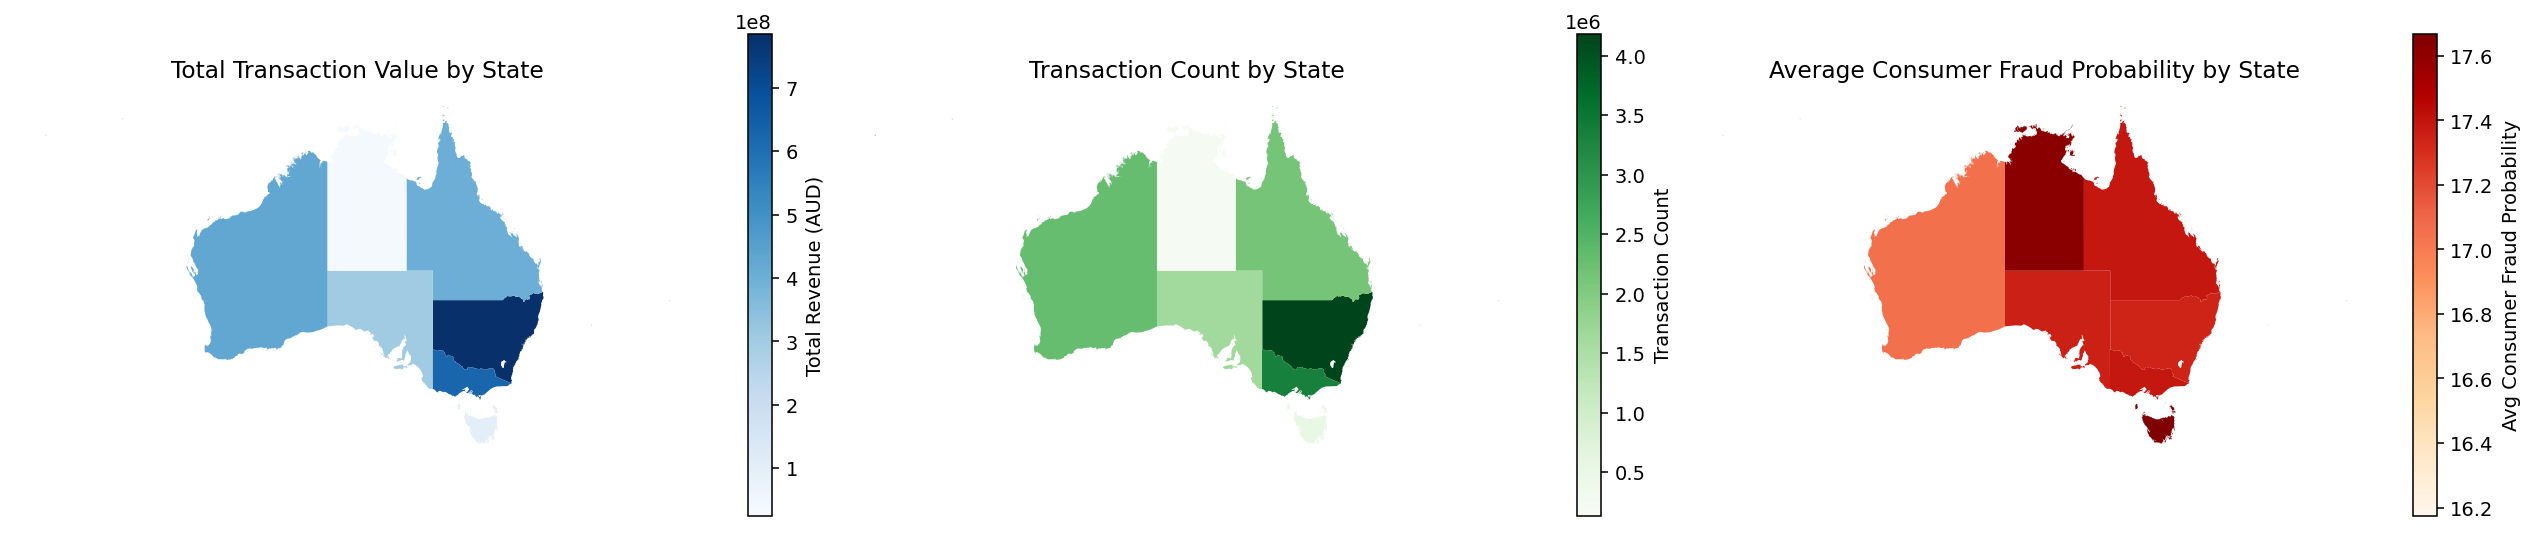

In [36]:
# Merge to the gdf
gdf_plot = gdf.merge(agg_pd, on="state", how="left")

# Unify the display style of the map
mpl.rcParams["figure.dpi"] = 140

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Total transaction amount
gdf_plot.plot(
    column="total_revenue",
    ax=axes[0],
    cmap="Blues",
    legend=True,
    legend_kwds={"label": "Total Revenue (AUD)", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[0].set_title("Total Transaction Value by State")
axes[0].axis("off")

# Transaction number
gdf_plot.plot(
    column="txn_count",
    ax=axes[1],
    cmap="Greens",
    legend=True,
    legend_kwds={"label": "Transaction Count", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[1].set_title("Transaction Count by State")
axes[1].axis("off")

# Average probability of consumer fraud
gdf_plot.plot(
    column="avg_c_fraud_prob",
    ax=axes[2],
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "Avg Consumer Fraud Probability", "shrink": 0.7},
    missing_kwds={"color":"lightgrey","hatch":"///","label":"No data"}
)
axes[2].set_title("Average Consumer Fraud Probability by State")
axes[2].axis("off")

# The description of "no data" in the unified legend (will only be displayed when there is indeed a deficiency)
handles, labels = axes[2].get_legend_handles_labels()
if "No data" in labels:
    fig.legend(handles, labels, loc="lower center", ncols=4, frameon=False)

plt.show()

In [37]:
# Save the output
output_path = "initial_transaction.parquet"

df_final.write.mode("overwrite").parquet(output_path)

print(f"Data saved as Parquet at {output_path}")

Data saved as Parquet at initial_transaction.parquet


In [ ]:
initial_transaction = spark.read.parquet("initial_transaction.parquet")
initial_transaction.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- year_month: string (nullable = true)
 |-- pop: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- assault: double (nullable = true)
 |-- homicide: double (nullable = true)
 |-- kidnapping: double (nullable = true)
 |-- sexual assault: double (nullable = true)
 |-- crime_index: double (nullable = true)
 |-- m_fraud_prob: double (nullable = true)
 |-- m_name: string (nullable = true)
 |-- c_fraud_prob: double (nullable = true)
 |-- m_category: string (nullable = true)
 |-- m_take_rate: double (nullable = true)

+------------+-----------+-----+--------+---

In [41]:
initial_transaction.show(100)

+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+-----------------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+--------------------+------------------+----------+-----------+
|merchant_abn|consumer_id|state|postcode|user_id|            order_id|      dollar_value|gender|order_datetime|year_month|              pop|median_income|mean_income|assault|homicide|kidnapping|sexual assault|crime_index|      m_fraud_prob|              m_name|      c_fraud_prob|m_category|m_take_rate|
+------------+-----------+-----+--------+-------+--------------------+------------------+------+--------------+----------+-----------------+-------------+-----------+-------+--------+----------+--------------+-----------+------------------+--------------------+------------------+----------+-----------+
| 33604812025|        551|  NSW|    2021|   3471|f381a114-18d7-4c7...|219.94202939977228